In [38]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import MessagesState
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from serpapi import search
import os

In [3]:
class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

In [39]:
serpapi_params = {
    "engine": "google",
    "api_key": os.environ["SERPAPI_KEY"]
}

@tool
def web_search(query: str) -> str:
    """Finds general knowledge information using Google search. Can also be used
    to augment more 'general' knowledge to a previous specialist query."""
    search = search({**serpapi_params, "q":query, "n": 3})
    results = search.get_dict()["organic_results"]
    contexts = "\n---\n".join(
         ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
        )
    
    return contexts

tools = [web_search]

In [11]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools)


In [43]:
output = llm_with_tools.invoke("What is the weather in Tokyo?")
output

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9NVTo63mB8AkRPoU5pVAgYVp', 'function': {'arguments': '{"query":"current weather in Tokyo"}', 'name': 'web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 71, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-132030db-7c98-4869-9810-9847cadb21cf-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'current weather in Tokyo'}, 'id': 'call_9NVTo63mB8AkRPoU5pVAgYVp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 71, 'output_tokens': 17, 'total_tokens': 88, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_d

In [46]:
output.tool_calls

[{'name': 'web_search',
  'args': {'query': 'current weather in Tokyo'},
  'id': 'call_9NVTo63mB8AkRPoU5pVAgYVp',
  'type': 'tool_call'}]

In [40]:
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [72]:
system_prompt = """
You take in a query and information about a topic and you compile a mini report on the subject.
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("user", "{messages}")
])

llm_writer = ChatOpenAI(model="gpt-4o-mini", temperature=0)

chain_writer = prompt | llm_writer

def write_report(state: MessagesState):
    research_information = state["messages"][-1].content
    state["messages"].append(HumanMessage(content=f"Write a mini report based on your findings: {research_information}"))
    return {"messages": [chain_writer.invoke(state["messages"])]}

def route_to_writer(state: MessagesState):
    if state["messages"][-1].tool_calls:
        return "tools"
    else:
        return "write_report"

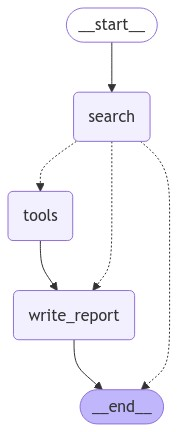

In [75]:
from IPython.display import Image, display

tools = [web_search]
builder = StateGraph(MessagesState)
builder.add_node("search", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_node("write_report", write_report)
builder.add_edge(START, "search")
builder.add_conditional_edges("search", route_to_writer)
builder.add_edge("tools", "write_report")
builder.add_edge("write_report", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

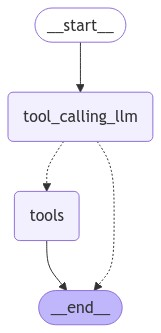

In [60]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
from IPython.display import Markdown

output = graph.invoke({"messages": [HumanMessage(content="Search online and write a mini report on the topic of why to use graphs to represent agentic workflows?")]})

Markdown(output["messages"][-1].content)

### Mini Report: The Importance of Using Graphs to Represent Agentic Workflows

#### Introduction
Agentic workflows refer to the processes and actions taken by agents (individuals or systems) to achieve specific goals. Representing these workflows visually through graphs can significantly enhance understanding, communication, and analysis. This report explores the reasons for using graphs in this context.

#### 1. Clarity and Comprehension
Graphs provide a clear visual representation of complex workflows, making it easier for stakeholders to understand the relationships and sequences of actions. By illustrating how different components interact, graphs can simplify intricate processes, allowing for quicker comprehension.

#### 2. Enhanced Communication
Visual aids like graphs facilitate better communication among team members and stakeholders. They serve as a common language that can bridge gaps between technical and non-technical individuals, ensuring that everyone involved has a shared understanding of the workflow.

#### 3. Identification of Patterns and Trends
Graphs can reveal patterns and trends within workflows that may not be immediately apparent through textual descriptions. By visualizing data points, agents can identify bottlenecks, redundancies, or inefficiencies, leading to more informed decision-making.

#### 4. Improved Analysis and Problem-Solving
When workflows are represented graphically, it becomes easier to analyze them for potential improvements. Graphs allow for the simulation of different scenarios, helping agents to foresee the outcomes of various actions and make adjustments accordingly.

#### 5. Documentation and Training
Graphs serve as effective documentation tools that can be used for training new team members. A visual representation of workflows can help newcomers grasp the processes more quickly than traditional documentation methods, leading to faster onboarding and increased productivity.

#### 6. Flexibility and Adaptability
Graphs can be easily modified to reflect changes in workflows, making them a flexible tool for ongoing process management. As workflows evolve, updating a graph can provide an immediate visual cue to all stakeholders about the new processes in place.

#### Conclusion
Using graphs to represent agentic workflows offers numerous advantages, including enhanced clarity, improved communication, and better analytical capabilities. As organizations increasingly rely on data-driven decision-making, the role of visual representations in understanding and optimizing workflows will continue to grow. Embracing graphical representations can lead to more efficient processes and ultimately contribute to achieving organizational goals.

In [28]:
output

{'messages': [HumanMessage(content='Search online and write a mini report on the topic of why to use graphs to represent agentic workflows?', additional_kwargs={}, response_metadata={}, id='c08b8097-ff96-4c0b-95c4-542ff62a958c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mC0I7OYcH1moOqeULvNhOwWx', 'function': {'arguments': '{"query":"why use graphs to represent agentic workflows"}', 'name': 'web_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 85, 'total_tokens': 106, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-635202ac-3d71-4b6c-bad2-fde842733af8-0', tool_calls=[{'name': 'web_search', '